Type 1. Independent Gaussian

$$
(x_1, x_2) \sim \mathcal{N}(0,I)
$$

Type 2. Correlated Gaussian

$$
(y_1, y_2) \sim \mathcal{N}(0,\begin{bmatrix}1&\rho\\ \rho&1\end{bmatrix})
$$

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [71]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                  size = 300)
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                  size = 300)

In [72]:
def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                data[marginal_index][:,1].reshape(-1,1)],
                                axis=1)
    return batch

<Axes: >

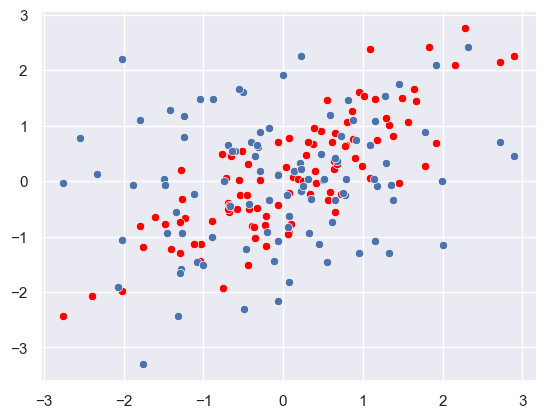

In [73]:
joint_data = sample_batch(y,batch_size=100,sample_mode='joint')
sns.scatterplot(x=joint_data[:,0],y=joint_data[:,1],color='red')
marginal_data = sample_batch(y,batch_size=100,sample_mode='marginal')
sns.scatterplot(x=marginal_data[:,0],y=marginal_data[:,1])

<Axes: >

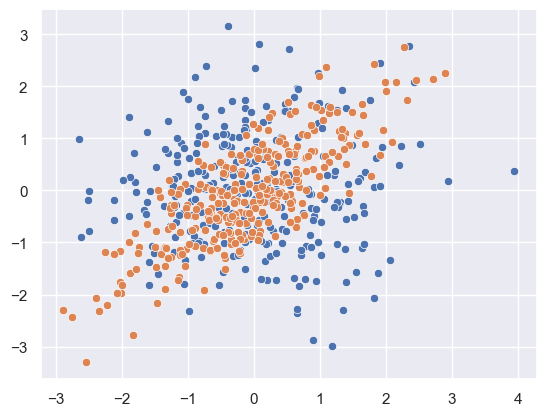

In [74]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])
# plt cor Gaussian
sns.scatterplot(x=y[:,0],y=y[:,1])

# Define MINE

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [76]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [77]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [78]:
def learn_mine(batch, mine_net, mine_net_optim, ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint))
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal))
    
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))

    ma_et = (1-ma_rate)*et + ma_rate*torch.mean(et) # ours
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et) #the internet's
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
    # loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, loss, ma_et

In [79]:
def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(5e+3), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    losses = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size), sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, loss, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result, losses

In [80]:
mine_net_indep = Mine()
mine_net_optim_indep = optim.Adam(mine_net_indep.parameters(), lr=1e-3)
result_indep, losses_indep = train(x, mine_net_indep, mine_net_optim_indep)

-6.211862e-05
-1.0046788e-06
0.0021012146
-1.3787358e-05
-2.7868082e-05


-4.206957e-06


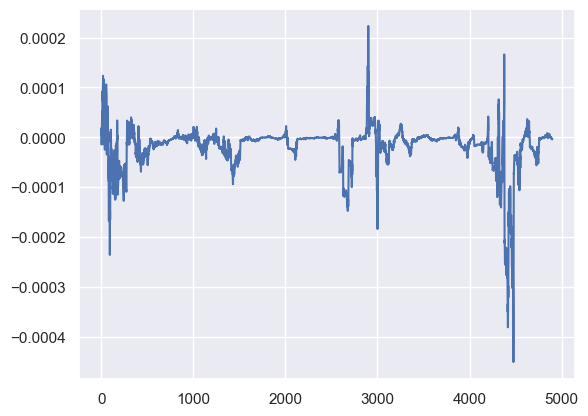

In [81]:
result_indep_ma = ma(result_indep)
print(result_indep_ma[-1])
plt.plot(range(len(result_indep_ma)),result_indep_ma)

0.9997425


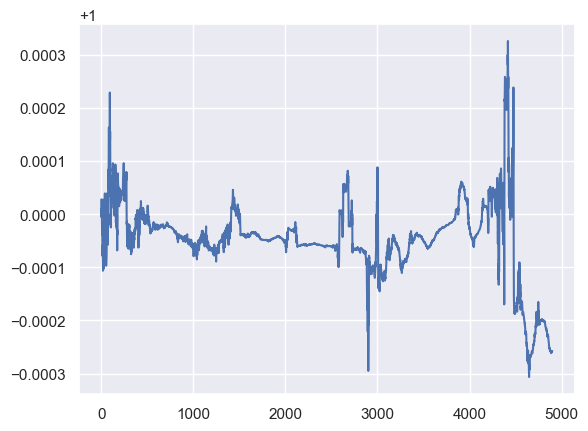

In [82]:
losses_indep_ma = ma(losses_indep)
print(losses_indep_ma[-1])
plt.plot(range(len(losses_indep_ma)),losses_indep_ma)

In [83]:
mine_net_cor = Mine()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor, loss_cor = train(y, mine_net_cor,mine_net_optim_cor)

0.48926228
0.4419347
0.5033231
0.39357102
0.2860782


0.49315035


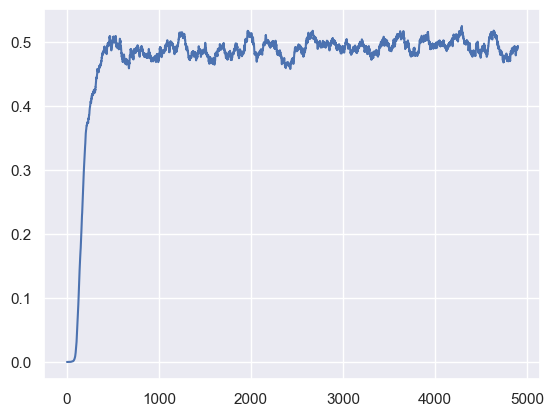

In [84]:
result_cor_ma = ma(result_cor)
print(result_cor_ma[-1])
plt.plot(range(len(result_cor_ma)),result_cor_ma)

0.55998945


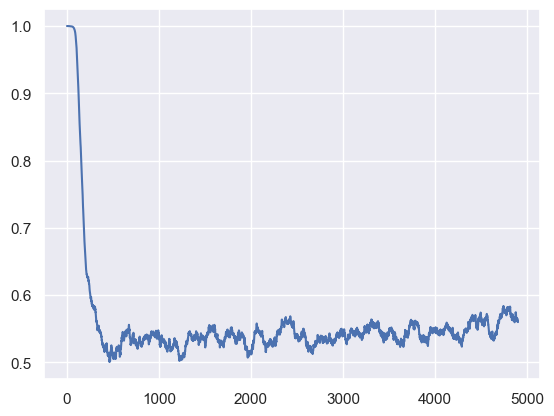

In [85]:
loss_cor_ma = ma(loss_cor)
print(loss_cor_ma[-1])
plt.plot(range(len(loss_cor_ma)), loss_cor_ma)

In [86]:
def learn_my_mine(batch, mine_net, mine_net_optim, ma_rate=0.01):

    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint))
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal))

    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    # the neural information measure by the Donskar-Varadhan representation
    nim = torch.mean(t) - torch.log(torch.mean(et))

    #Using exponantial moving average to correct bias
    ma_et = (1-ma_rate)*et + ma_rate*torch.mean(et)
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()

    return nim, loss

def train_my_net(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(5e+3), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    losses = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size), sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, loss = learn_my_mine(batch, mine_net, mine_net_optim)
        result.append(mi_lb.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result, losses


In [87]:
indep = Mine()
optim_indep = optim.Adam(indep.parameters(), lr=1e-3)
res_indep, los_indep = train_my_net(x, indep, optim_indep)


-7.4505806e-06
-9.652972e-05
8.791685e-06
-9.834766e-06
-4.7683716e-06


-3.4689904e-07


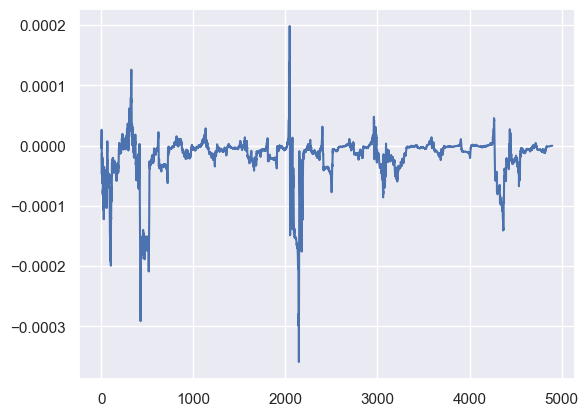

In [88]:
res_indep_ma = ma(res_indep)
print(res_indep_ma[-1])
plt.plot(range(len(res_indep_ma)),res_indep_ma)

0.30827653


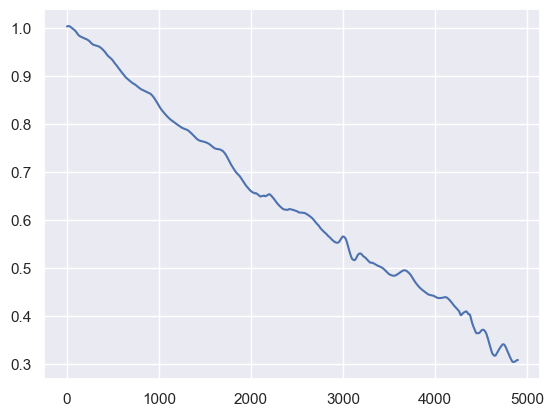

In [89]:
loss_indep_ma = ma(los_indep)
plt.plot(range(len(loss_indep_ma)),loss_indep_ma)

In [90]:
cor = Mine()
optim_cor = optim.Adam(cor.parameters(), lr=1e-3)
res_cor, los_cor = train_my_net(y, cor, optim_cor)

0.41426563
0.7832551
0.6161852
0.51904774
0.6054106


0.51301706


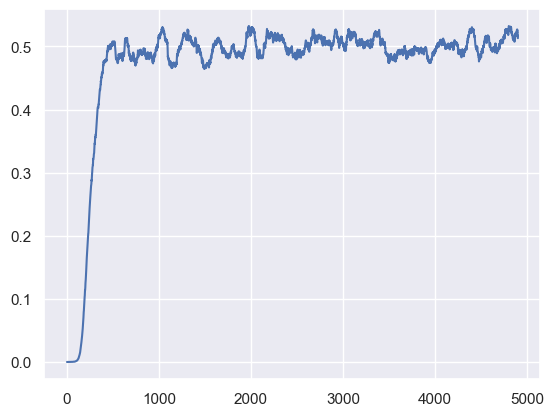

In [91]:
res_cor_ma = ma(res_cor)
print(res_cor_ma[-1])
plt.plot(range(len(res_cor_ma)),res_cor_ma)

-4.8955617


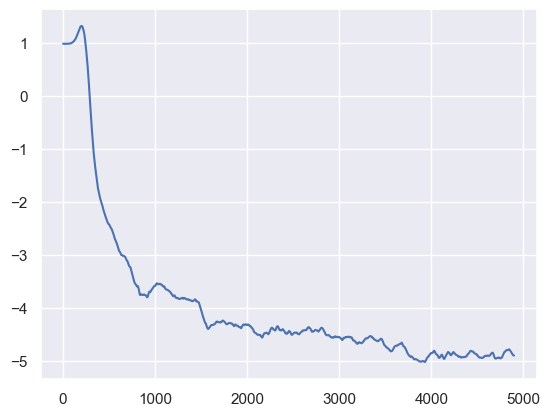

In [92]:
losses_cor_ma = ma(los_cor)
plt.plot(range(len(losses_cor_ma)),losses_cor_ma)